In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,textwrap,matplotlib,sklearn,gseapy,topicpy -a Filippo_Valle -g -r -b -w

Filippo_Valle 
last updated: Mon Aug 31 2020 

CPython 3.8.5
IPython 7.17.0

pandas 1.1.1
numpy 1.19.1
textwrap unknown
matplotlib 3.2.2
sklearn 0.0
gseapy 0.10.1
topicpy 1.1.0

compiler   : GCC 7.5.0
system     : Linux
release    : 4.19.76-linuxkit
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 
Git repo   : 
Git branch : 
watermark 2.0.2


In [2]:
import numpy as np
import pandas as pd
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as mticker
import sys, os
from topicpy.hsbmpy import plot_topic_size, get_max_available_L
from topicpy.hypergeom import parameters_for_hypergeometric, build_map, plot_map

In [3]:
directory=f"{os.getcwd()}/datasets/gtex10/"
os.chdir(directory)
sys.path.append('/home/jovyan/work/phd/')

In [4]:
L = get_max_available_L(directory)

In [5]:
df = pd.read_csv("mainTable.csv", index_col=[0])

# Geneontology

In [ ]:
from topicpy.geneontology import get_ontology_df, ensg_to_symbol
from topicpy.tableanalyser import get_symbol
import gseapy as gs

In [ ]:
l=L-1
print(f"level {l}")
algorithm = "topsbm"
df_topics = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_topics.csv")
df_topics_smooth = pd.read_csv(f"{directory}/{algorithm}/{algorithm}_level_{l}_word-dist.csv",index_col=0)
df_topics_smooth.index = [g[:15] for g in df_topics_smooth.index]

In [ ]:
def get_topic_over_thr(topic_name, q=0.75):
    topic = df_topics_smooth[topic_name]
    topic = topic[topic>0]
    topic = topic[topic>topic.quantile(q=q)]
    return topic.sort_values(ascending=False)

In [ ]:
df_symbols= pd.read_csv("https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_pub_ensembl_id&col=md_ensembl_id&col=md_eg_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit", index_col=[0], sep='\t')

In [ ]:
def get_sea():
    for g in df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]:
        yield get_symbol(g)

In [ ]:
with open("gback.txt",'w') as f:
    list(map(lambda x: f.writelines(x+'\n')if len(x)>1 else None, get_sea()))
    
with open("gback_ensg.txt",'w') as f:
    list(map(lambda x: f.writelines(x[:15]+'\n')if len(x)>1 else None, df_topics.values.ravel()[[str(s)!='nan' for s in df_topics.values.ravel()]]))

In [ ]:
gs.get_library_name()

In [ ]:
#https://www.gsea-msigdb.org/gsea/downloads.jsp
gene_sets = ['GO_Molecular_Function_2018',
             'GO_Biological_Process_2018',
             'GO_Cellular_Component_2018',
             'Human_Phenotype_Ontology',
             'WikiPathways_2019_Human',
             '/home/jovyan/work/phd/MSigDB/c1.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c2.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c3.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c4.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c5.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c6.all.v7.1.symbols.gmt',
             '/home/jovyan/work/phd/MSigDB/c7.all.v7.1.symbols.gmt',
            ]

In [ ]:
threshhold = 5e-1
cutoff = 5e-1
background = len([g for g in get_sea()])
os.system("mkdir -p gsea")
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("gsea/gsea_level_%d_topic_%d.csv"%(l,itopic+1), index_col=[0])
        print(topic)
    except:
        try:
            gene_list = ensg_to_symbol(df_topics.loc[:,topic].dropna().values)
            #gene_list = ensg_to_symbol(get_topic_over_thr(topic).index)
            print(topic)
            enriched_topic = get_ontology_df(gene_list, cutoff=cutoff, threshhold = threshhold, gene_sets = gene_sets, background=background)
            enriched_topic = enriched_topic.sort_values(by=['Adjusted P-value'], ascending=True)[:20]
            enriched_topic.to_csv("gsea/gsea_level_%d_topic_%d.csv"%(l,itopic+1))
        except:
            print(*sys.exc_info())
            continue
    print(enriched_topic)

In [ ]:
topic_pvalues = []
topic_gos = []
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("gsea/gsea_level_%d_topic_%d.csv"%(l,itopic+1))
        if len(enriched_topic.index) >0:
            p_val = np.sort(enriched_topic['Adjusted P-value'])[0]
            topic_pvalues.append(-np.log10(p_val))
            for goc in enriched_topic['Gene_set'][:10].unique():
                topic_gos.append(goc)
        print(topic)
    except:
        print("error", sys.exc_info()[0])

In [ ]:
fig = plt.figure(figsize=(18,15))
x = np.arange(1,1+len(topic_pvalues))
c, _, _ = plt.hist(topic_pvalues, histtype='step', lw=20, bins=45, color="gray")
plt.vlines(-np.log10(0.05),0,np.max(c)*1.1, color="red", ls='--', lw=10, label="$\\alpha=0.05$")
plt.xlabel('-log(P-value)', fontsize=35)
plt.ylabel("number of topics", fontsize=35)
#plt.ylim(0,0.055)
#plt.yscale('log')
plt.legend(fontsize=35)
plt.tick_params(which="both",labelsize=35)
fig.savefig("%s/pvaluescrosstopic(%d).pdf"%(directory,l))

In [ ]:
fig = plt.figure(figsize=(18,20))
gos, goscounts = np.unique(topic_gos, return_counts=True)
plt.barh(["\n".join(wrap(str(l).replace('_',' '),20)) for l in gos], goscounts)
plt.yticks(fontsize=15)
plt.tick_params(which="both",labelsize=35)
plt.tight_layout()
plt.show()
fig.savefig("%s/pvaluecategories(%d).pdf"%(directory,l))

# hypergeometric operlaps

In [6]:
from scipy.stats import hypergeom
from sklearn.metrics import v_measure_score
import seaborn as sns
sns.set_context('paper')

In [7]:
hsbm_list_topics = pd.read_csv("topsbm/topsbm_level_3_topics.csv")
gene_list = hsbm_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
hsbm_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in hsbm_list_topics.columns:
    hsbm_list[[g[:15] for g in hsbm_list_topics[topic].dropna()]]=topic

In [8]:
hsbm_list_topics = pd.read_csv("topsbm-log/topsbm-log_level_3_topics.csv")
gene_list = hsbm_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
hsbm_log_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in hsbm_list_topics.columns:
    hsbm_log_list[[g[:15] for g in hsbm_list_topics[topic].dropna()]]=topic

In [9]:
wgcna_list_topics = pd.read_csv("wgcna/wgcna_level_0_topics.csv")
gene_list = wgcna_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
wgcna_list=pd.Series(index=np.unique([g[:15] for g in gene_list]), dtype=str)
for topic in wgcna_list_topics.columns:
    wgcna_list[np.unique([g[:15] for g in wgcna_list_topics[topic].dropna()])]=topic

In [10]:
tm_list_topics = pd.read_csv("tm/tm_level_0_topics.csv")
gene_list = tm_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
tm_list=pd.Series(index=np.unique([g[:15] for g in gene_list]), dtype=str)
for topic in tm_list_topics.columns:
    tm_list[np.unique([g[:15] for g in tm_list_topics[topic].dropna()])]=topic

In [11]:
lda_list_topics = pd.read_csv("lda/lda_level_1_topics.csv")
gene_list = lda_list_topics.values.ravel().astype(str)
gene_list = list(map(lambda g: g[:15],filter(lambda g: g!="nan", gene_list)))
lda_list=pd.Series(index=[g[:15] for g in gene_list], dtype=str)
for topic in lda_list_topics.columns:
    lda_list[lda_list.index.isin([g[:15] for g in lda_list_topics[topic].dropna()])]=topic
lda_list=lda_list.reset_index().drop_duplicates("index").set_index("index")
lda_list=pd.Series(index=lda_list.index, data=lda_list.values.ravel())

In [12]:
def run(first_name, last_name):
    list_1 = globals()[f"{first_name}_list"]
    list_2 = globals()[f"{last_name}_list"]

    #to uniform
    list_1 = list_1[list_1.index.isin(list_2.index)]
    list_2 = list_2[list_2.index.isin(list_1.index)]
    hyper_params = parameters_for_hypergeometric(list_1, list_2)
    df_cmap = build_map(*hyper_params)
    df_cmap[df_cmap<3]=0
    df_cmap = df_cmap.sort_values(by=[t for t in df_cmap.columns], ascending=False)
    plot_map(df_cmap, first_name=first_name, last_name=last_name)

(4, 5)


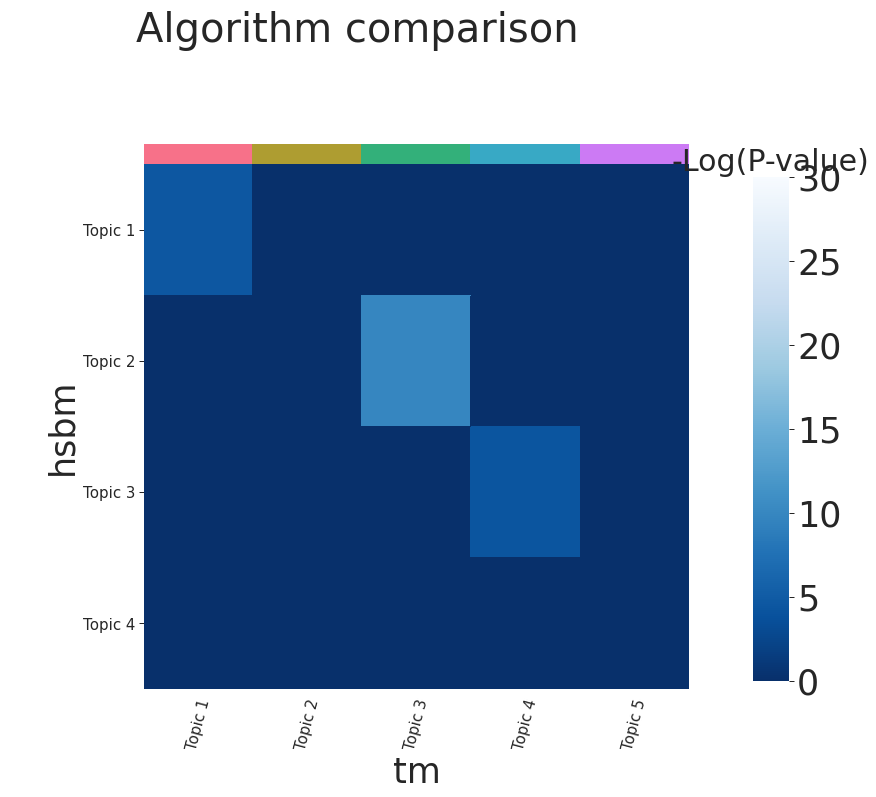

(4, 8)


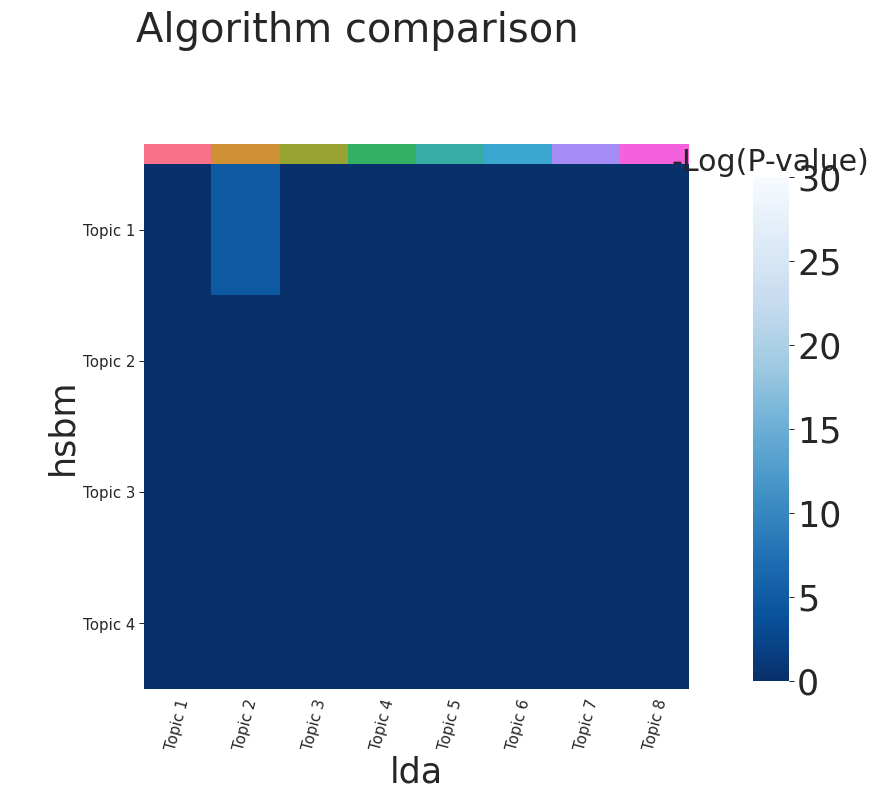

(8, 21)


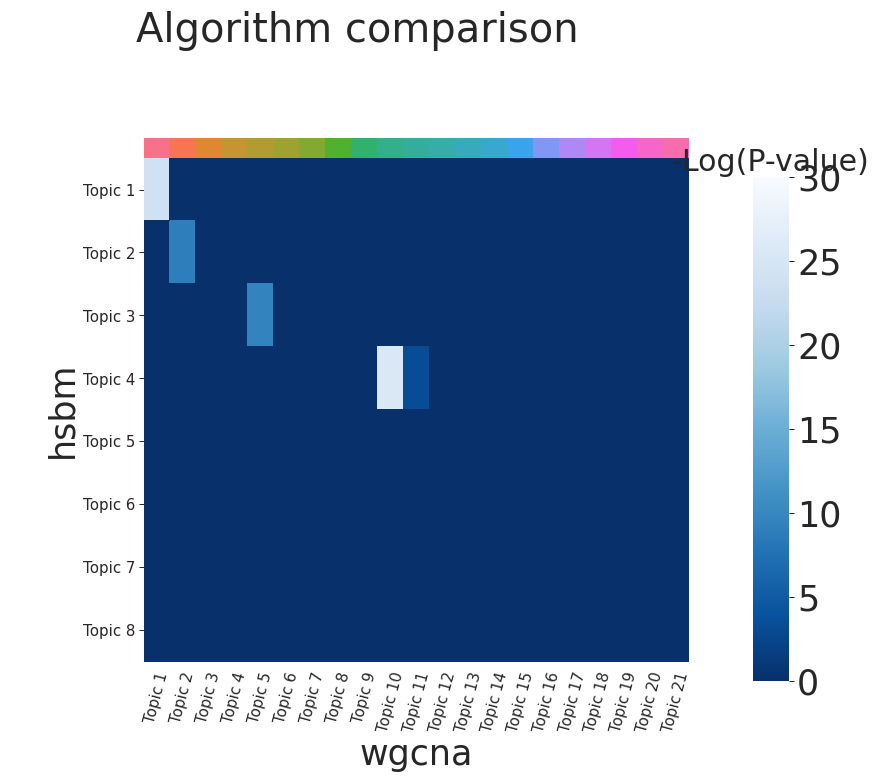

(4, 6)


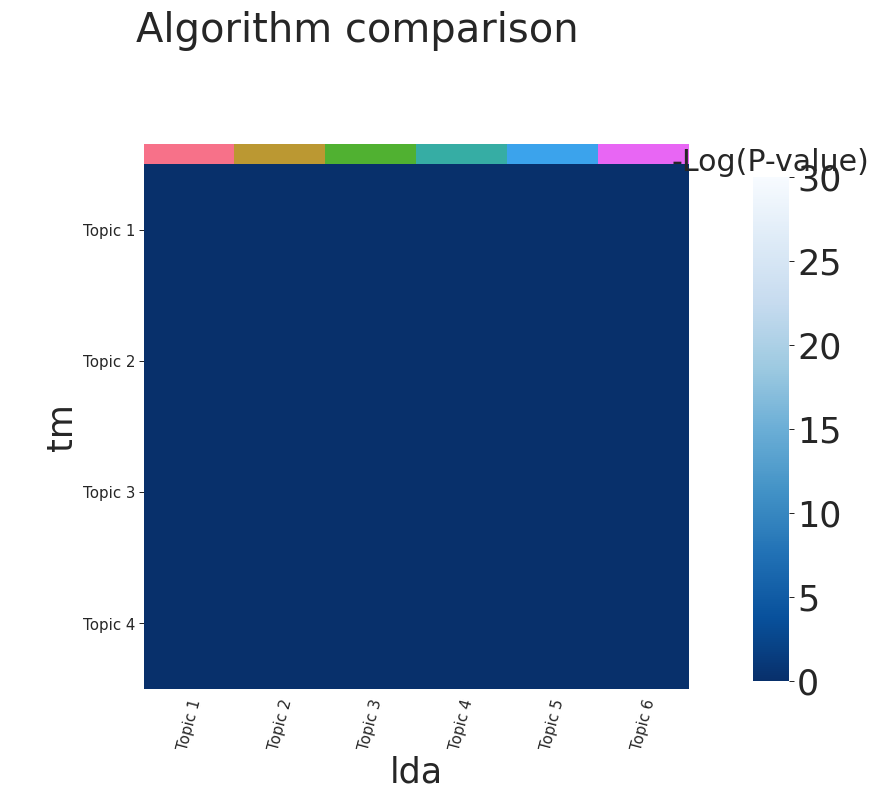

(5, 9)


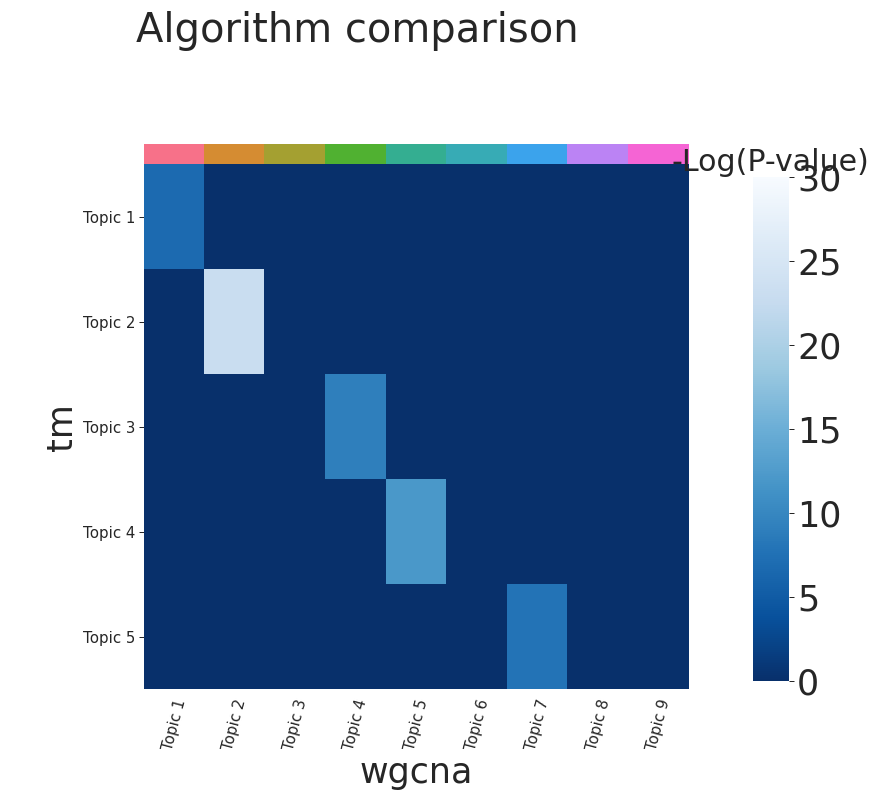

(8, 14)


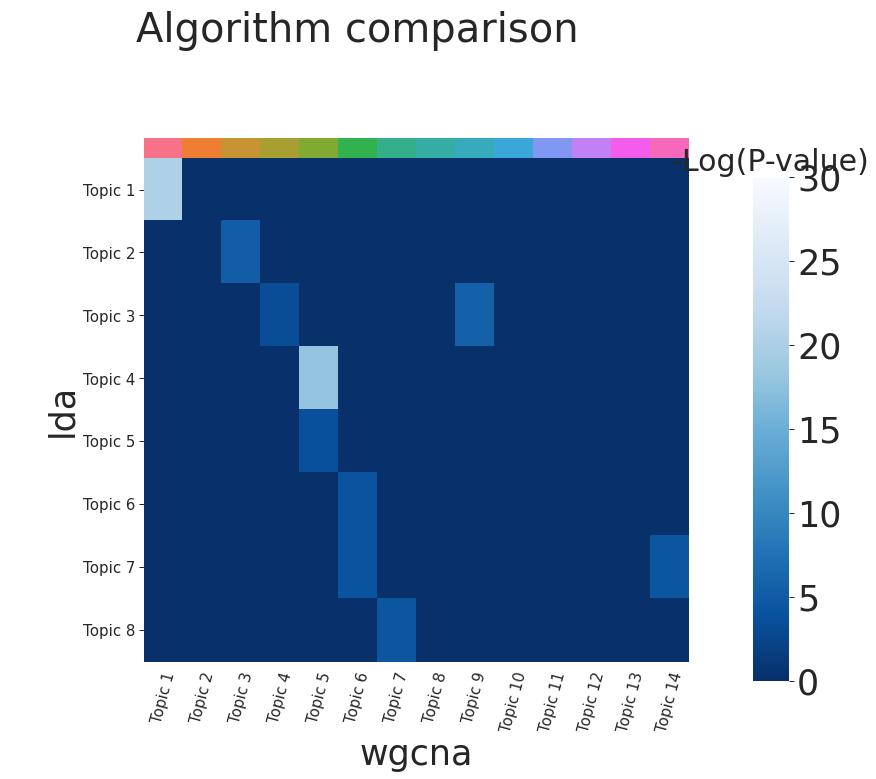

In [13]:
run("hsbm","tm")
run("hsbm","lda")
run("hsbm","wgcna")
run("tm","lda")
run("tm","wgcna")
run("lda","wgcna")

In [14]:
print("hsbm & tm %.3f \\\\ \hline"%v_measure_score(hsbm_list.reindex_like(tm_list).dropna(), tm_list.reindex_like(hsbm_list).dropna()))
print("hsbm & lda %.3f \\\\ \hline"%v_measure_score(hsbm_list.reindex_like(lda_list).dropna(), lda_list.reindex_like(hsbm_list).dropna()))
print("hsbm & wgcna %.3f \\\\ \hline"%v_measure_score(hsbm_list.reindex_like(wgcna_list).dropna(), wgcna_list.reindex_like(hsbm_list).dropna()))
print("tm & lda %.3f \\\\ \hline"%v_measure_score(tm_list.reindex_like(lda_list).dropna(), lda_list.reindex_like(tm_list).dropna()))
print("tm & wgcna %.3f \\\\ \hline"%v_measure_score(tm_list.reindex_like(wgcna_list).dropna(), wgcna_list.reindex_like(tm_list).dropna()))
print("lda & wgcna %.3f \\\\ \hline"%v_measure_score(lda_list.reindex_like(wgcna_list).dropna(), wgcna_list.reindex_like(lda_list).dropna()))

hsbm & tm 0.015 \\ \hline
hsbm & lda 0.028 \\ \hline
hsbm & wgcna 0.011 \\ \hline
tm & lda 0.293 \\ \hline
tm & wgcna 0.656 \\ \hline
lda & wgcna 0.181 \\ \hline


In [15]:
print('df_algs.at["tm", "topsbm"]=%f'%v_measure_score(hsbm_list.reindex_like(tm_list).dropna(), tm_list.reindex_like(hsbm_list).dropna()))
print('df_algs.at["lda", "topsbm"]=%f'%v_measure_score(hsbm_list.reindex_like(lda_list).dropna(), lda_list.reindex_like(hsbm_list).dropna()))
print('df_algs.at["wgcna", "topsbm"]=%f'%v_measure_score(hsbm_list.reindex_like(wgcna_list).dropna(),  wgcna_list.reindex_like(hsbm_list).dropna()))
print('df_algs.at["lda", "tm"]=%f'%v_measure_score(tm_list.reindex_like(lda_list).dropna(), lda_list.reindex_like(tm_list).dropna()))
print('df_algs.at["wgcna", "tm"]=%f'%v_measure_score(tm_list.reindex_like(wgcna_list).dropna(), wgcna_list.reindex_like(tm_list).dropna()))
print('df_algs.at["wgcna", "lda"]=%f'%v_measure_score(lda_list.reindex_like(wgcna_list).dropna(), wgcna_list.reindex_like(lda_list).dropna()))

df_algs.at["tm", "topsbm"]=0.014612
df_algs.at["lda", "topsbm"]=0.027809
df_algs.at["wgcna", "topsbm"]=0.011345
df_algs.at["lda", "tm"]=0.293432
df_algs.at["wgcna", "tm"]=0.655752
df_algs.at["wgcna", "lda"]=0.181433
